## Tutorial 6: Detecting and Picking earthquakes

In this demonstration we will show how to automatically detect and pick earthquakes using OBS data. We will use example data from the [YH.LOBS6](https://ds.iris.edu/gmap/#network=YH&starttime=2014-01-01&endtime=2015-06-01&planet=earth) station from the HOBITSS deployment in 2014-2015.

First, we import the seisbench package and pre-trained models, as well as other required packages and modules to import data and make plots.

In [1]:
# SeisBench models
import seisbench.models as sbm

# ObsPy classes
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Numpy and Matplotlib for numerical calculations and plotting
import numpy as np
import matplotlib.pyplot as plt

### Load pre-trained DL models

Next, we load the pre-trained [OBSTransformer](https://github.com/alirezaniki/OBSTransformer) model weights. OBSTransformer is based on the EQTransformer architecture but has been trained on additional data: `'obst2024'`, which we need to specify here. 

In [2]:
obst_model = sbm.OBSTransformer.from_pretrained('obst2024')

We can also load a different model (here, [PickBlue](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023EA003332)) based on either the PhaseNet or EQTransformer architecture but trained using OBS data to compare the performance with OBSTransformer.

In [3]:
pblue_model = sbm.PickBlue(base='EQTransformer')

### Get waveform data

We will look at one station with 4-component data (YH.LOBS6) for a 1-hour long period that includes a magnitude [4.6 earthquake](https://www.geonet.org.nz/earthquake/technical/2014p742742) in the vicinity of the HOBITSS deployment.

In [4]:
# Initialize FDSN client - default is "IRIS", where the YH data are stored.
client = Client()

# Define the start time in UTC
t = UTCDateTime(2014, 10, 2, 19, 33)

# Get waveform data
stream = client.get_waveforms(network="YH", station="LOBS6", location="*", channel="HH?", starttime=t, endtime=t+3600)

Make a figure of the 4-component data, filtered between 1 and 10 Hz.

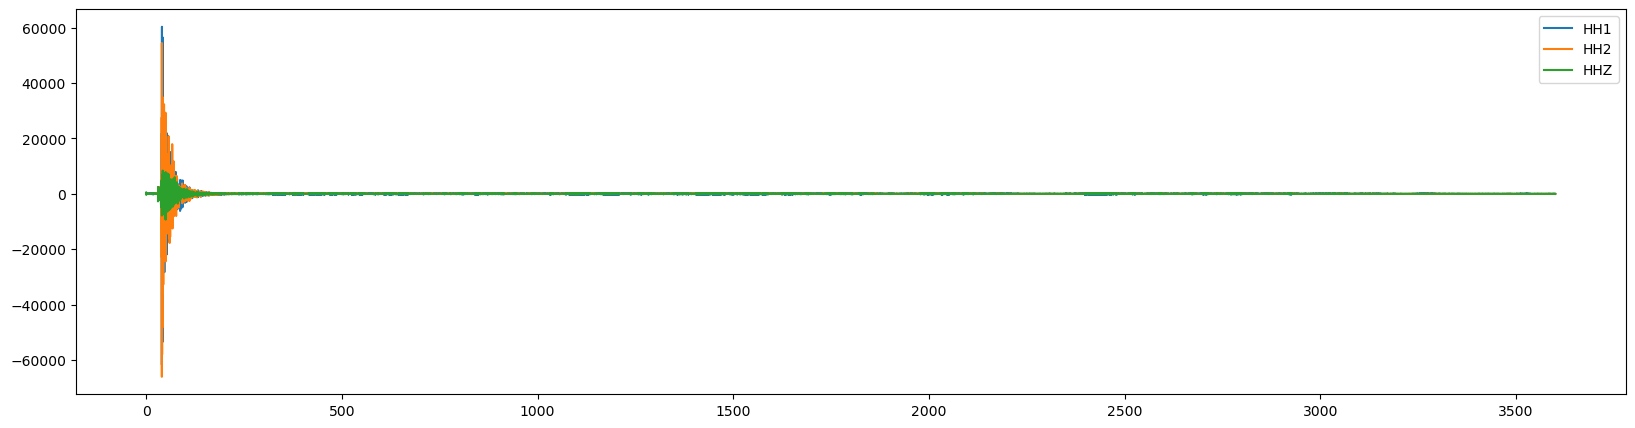

In [5]:
# Initialize the figure and add a single subplot
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

# Loop over the 3 components (traces) in the stream and plot them
for i in range(3):
    ax.plot(stream[i].times(), stream[i].filter('bandpass', freqmin=1., freqmax=10.).data, label=stream[i].stats.channel)

# Add a legend
ax.legend();

### Annotate waveforms (i.e., predict earthquake detection windows and phase picks)

This task is as simple as calling the `annotate()` method using the stream of data with the corresponding DL model.

In [6]:
# OBSTransformer model
obst_preds = obst_model.annotate(stream)

# PickBlue model
pblue_preds = pblue_model.annotate(stream)

Next, we visualize the annotations by plotting the probabilities in 5-minute slices.

In [7]:
# Length of window slice in seconds
wlength = 5 * 60

Now we make the plot and compare the predictions between OBSTransformer and PickBlue

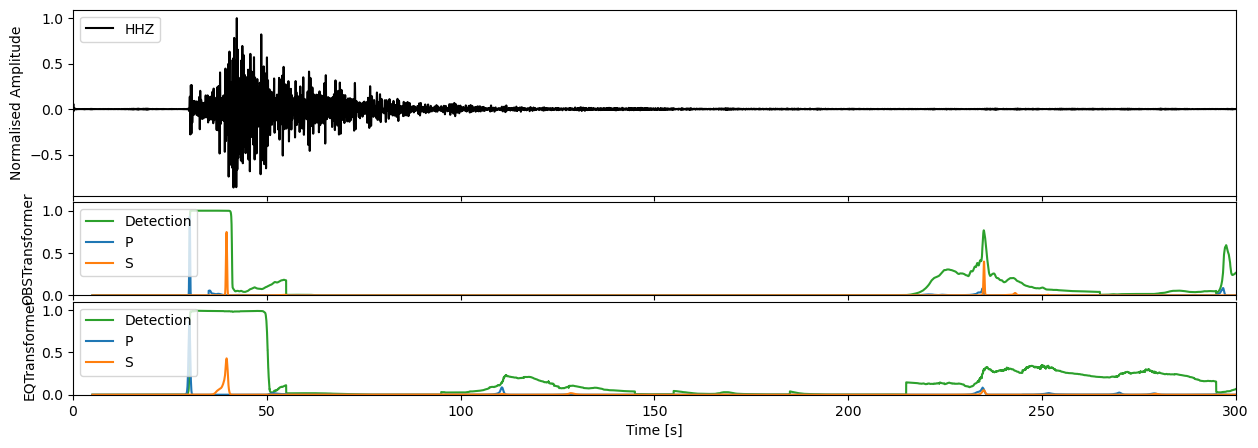

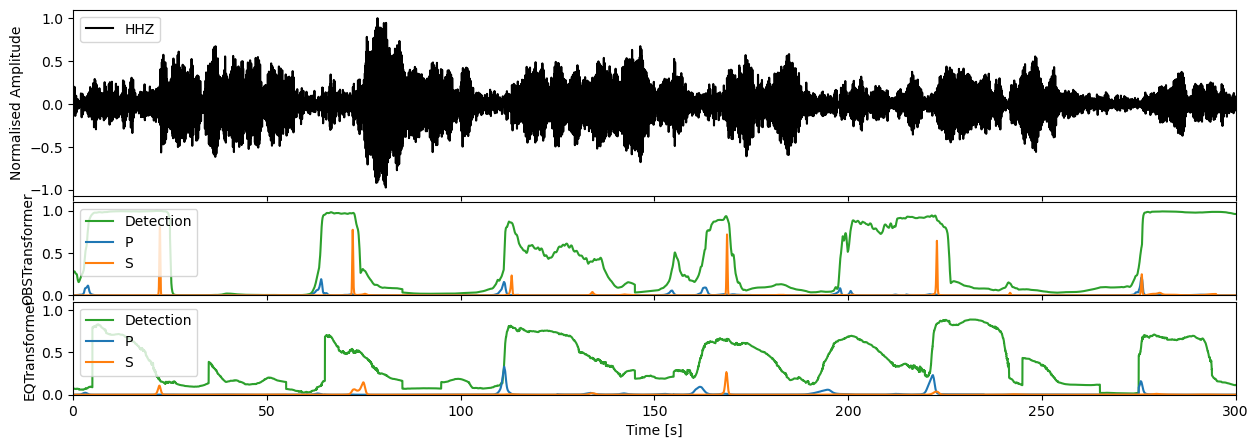

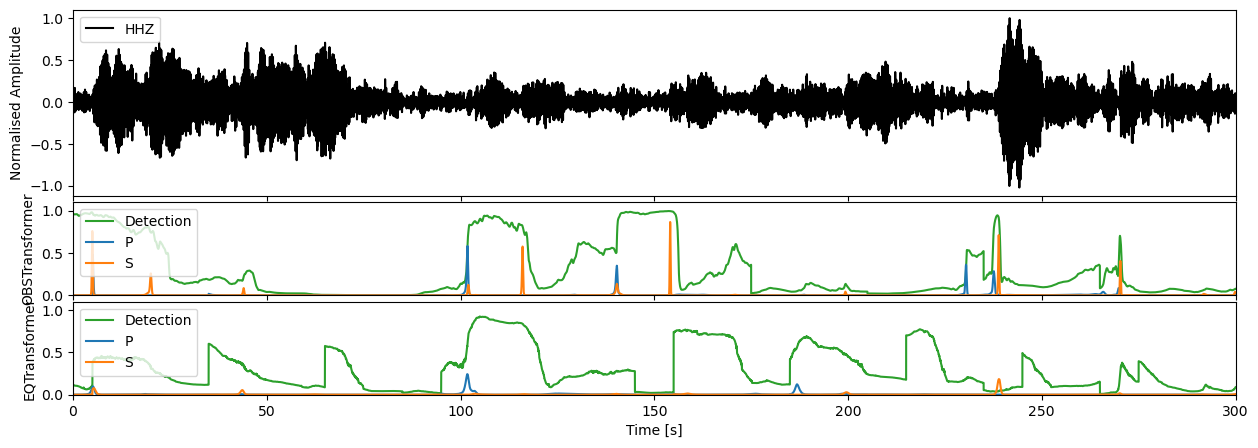

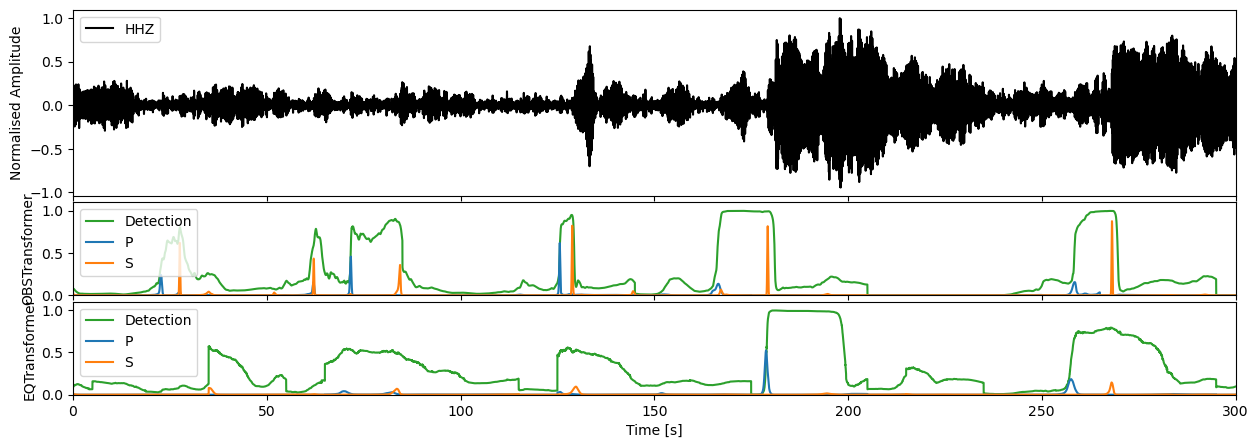

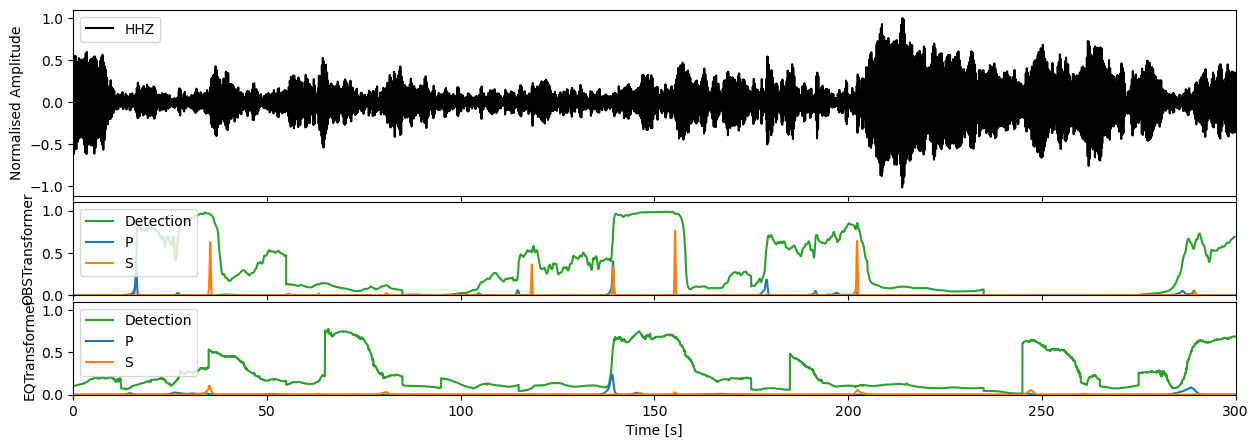

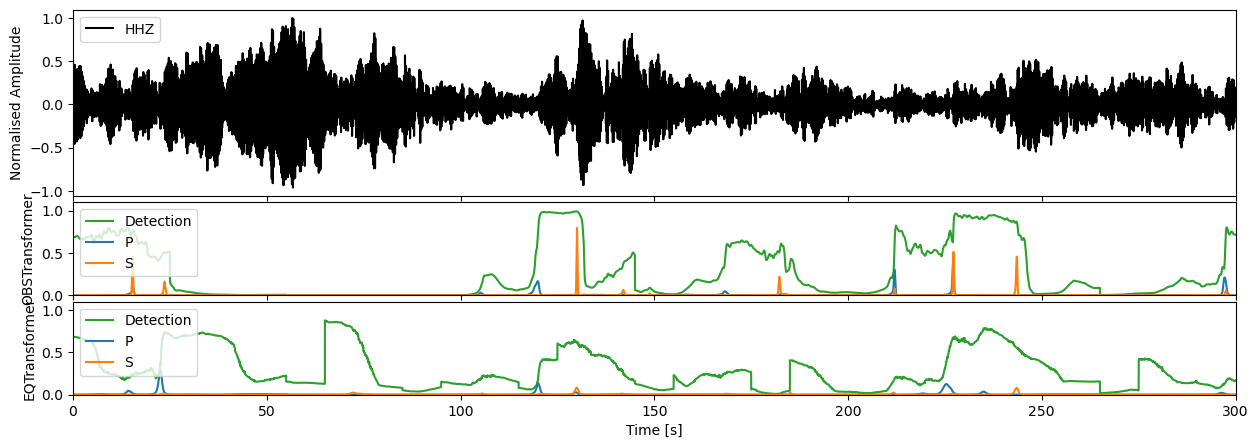

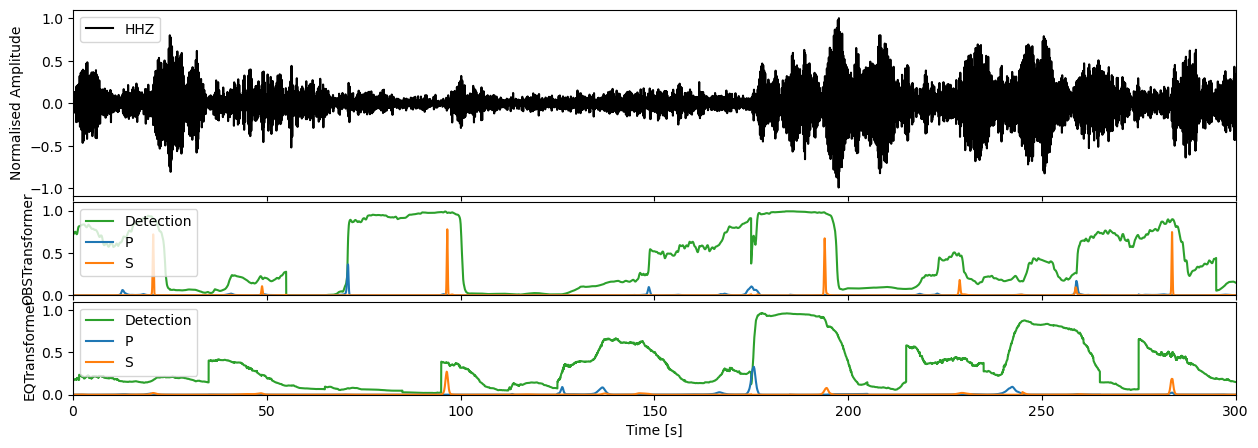

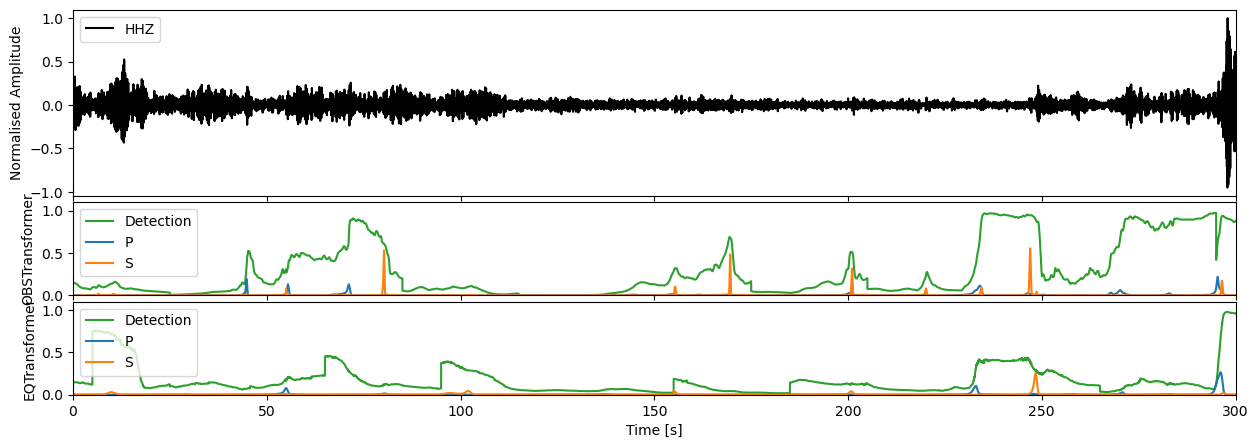

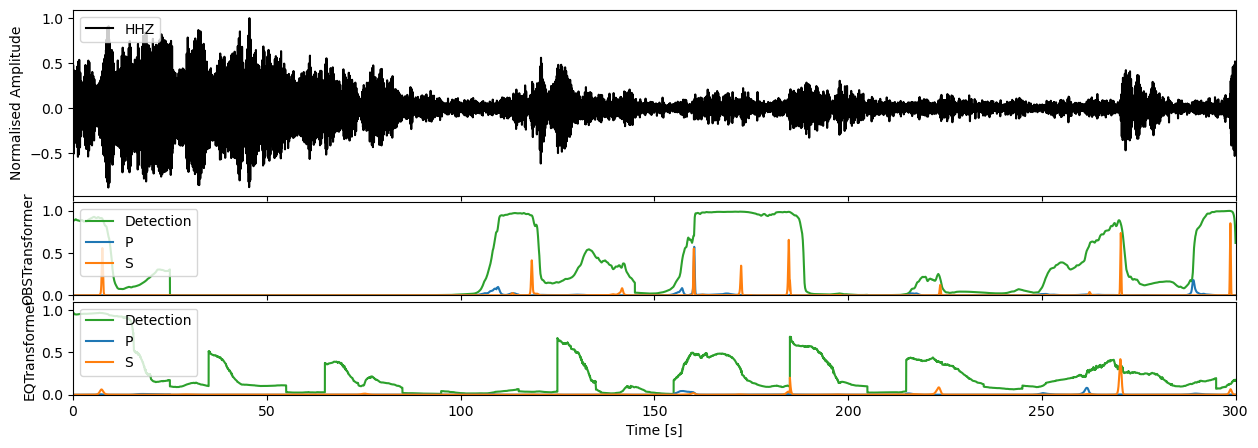

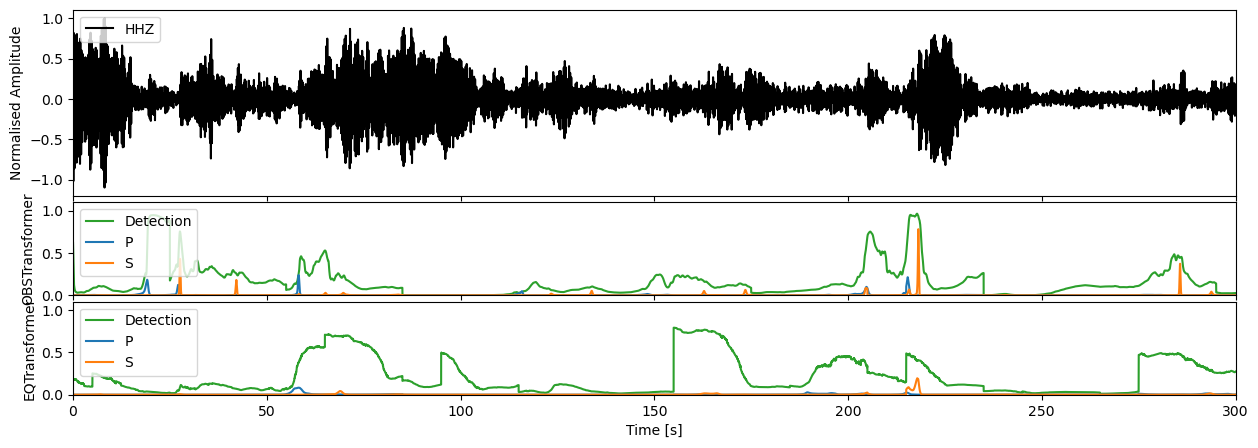

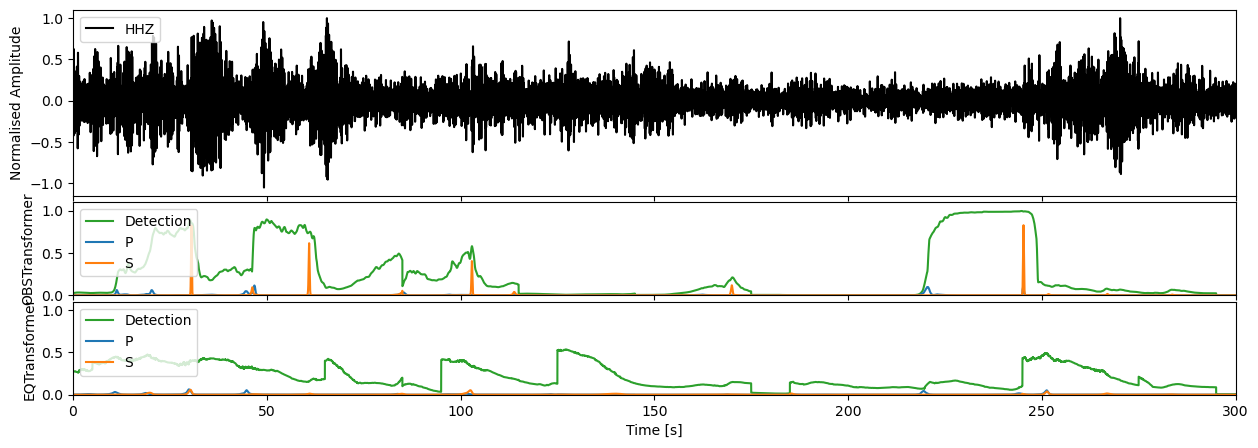

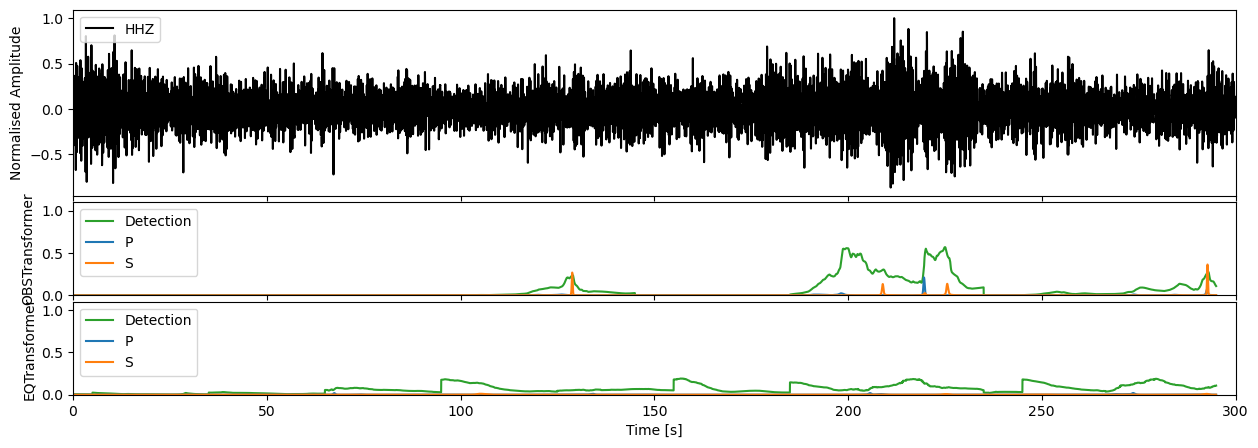

In [12]:
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}

for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream.slice(t0, t1).filter('bandpass', freqmin=2., freqmax=10., corners=2, zerophase=True)

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1, 1]})
    
    for i, preds in enumerate([obst_preds, pblue_preds]):
        subpreds = preds.slice(t0, t1)
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")
            if pred_class == "N":
                # Skip noise traces
                continue
            c = color_dict[pred_class]
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i + 1].set_ylabel(model)
        ax[i + 1].legend(loc=2)
        ax[i + 1].set_ylim(0, 1.1)
    
    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].set_ylabel('Normalised Amplitude')
    ax[2].set_xlabel('Time [s]')
    ax[0].legend(loc=2)
    plt.show()